<a href="https://colab.research.google.com/github/casalazara/Machine-Learning-IELE/blob/master/Proyecto/Proyecto_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np 
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow import keras
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split

# Carga de datos

## Directorio con los datos

In [30]:
drive.mount('/gdrive')
path = "../gdrive/MyDrive/Data"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


## Separación de los datos

In [3]:
data = []
labels = []
genres = ["Cumbia","Vallenato","Salsa","Merengue","Bachata"]
for i in range(len(genres)):   
    genre=genres[i]
    for img in os.listdir(path+"/"+genre):
      image=tf.keras.preprocessing.image.load_img(path+"/"+genre+"/"+img, color_mode='rgb', target_size= (300,300))
      image=np.array(image)
      data.append(image)
      labels.append(i)

data = np.array(data)
labels = np.array(labels)
labels = to_categorical(labels, 5)
X_train, X_test_val, y_train, y_test_val = train_test_split(data, labels, test_size=0.2, random_state=42)
X_test,X_val,y_test,y_val = train_test_split(X_test_val,y_test_val,test_size=.5,random_state=42)
X_train.shape, X_test.shape, X_val.shape

((1200, 300, 300, 3), (150, 300, 300, 3), (150, 300, 300, 3))

In [4]:
X_train[:2]

array([[[[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        ...,

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
         [255, 255, 255],
         [255, 255, 255]],

        [[255, 255, 255],
         [255, 255, 255],
         [255, 255, 255],
         ...,
         [255, 255, 255],
        

In [5]:
y_train[:2]

array([[0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [6]:
# Create an ImageDataGenerator
train_datagen = ImageDataGenerator(rescale = 1./255.)
validation_datagen = ImageDataGenerator(rescale = 1./255.)
X_test = X_test/255.
train_generator = train_datagen.flow(X_train, y_train, batch_size=8)
validation_generator = validation_datagen.flow(X_val, y_val, batch_size=8)

# Modelo


## Carga del modelo

In [7]:
model=VGG16(include_top=False,input_shape=(300,300,3))

#Congelamiento de capas

In [8]:
for layer in model.layers:
    layer.trainable=False

## Últimas capas

In [9]:
output=model.layers[-1].output
model_final=tf.keras.layers.Flatten()(output)
model_final=tf.keras.layers.Dense(512,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(64,activation='relu')(model_final)
model_final=tf.keras.layers.Dense(5,activation='softmax')(model_final)

## Modelo final

In [10]:
model=tf.keras.models.Model(model.input,model_final)

## Callback

In [11]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, weights_dir, patience=10, rate=0.5):
        """
        Initializer Method
        :param weights_dir: The directory of the model weights
        :param patience: Number of epochs before reducing lr
        :param rate: The rate to reduce the lr
        """
        super(CustomCallback, self).__init__()
        self.weights_dir = weights_dir
        self.rate = rate
        self.patience = patience

    def on_train_begin(self, logs=None):
        """
        Configurations to be taken an account on
        before training begins.
        :param logs: The logs from the output.
        """
        self.best_loss = np.Inf
        self.best_acc = 0
        self.wait = 0
        self.best_weights = None
    
    def on_epoch_end(self, epoch, logs=None):
        """
        Method that is called each time an epoch ends
        excecution
        :param epoch: The current epoch of the training
        :param logs: The logs from the output from an epoch ended
        """
        # Current validation loss
        current_loss = logs.get("val_loss")
        # Current validation Accuracy
        current_acc = logs.get("val_acc")
        if (current_loss < self.best_loss and 
            current_acc > self.best_acc):
            # We save the model weights
            # We wait again
            # We assign the best loss and the best accuracy.
            self.wait = 0
            self.best_loss = current_loss
            self.best_acc = current_acc
            self.model.save_weights(self.weights_dir)
            self.best_weights = self.model.get_weights()
            print("\nBest Weights Saved!!")
        else:
            self.wait += 1
            if self.wait >= self.patience:
                # Reduce learning rate by the initialized rate.
                self.wait = 0
                print(f"\nEpoch {epoch}, Reducing Learning Rate")
                # We set the new learning rate
                lr = K.get_value(self.model.optimizer.lr)
                new_lr = lr * self.rate
                K.set_value(self.model.optimizer.lr, new_lr)
                print(f"\nLearning Rate Reduced: {new_lr}")
                # We load the best weights to continue the training.
                self.model.set_weights(self.best_weights)
                print("\nBest Weights Loaded!!")


## Compilación

In [12]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

## Resumen del modelo

In [13]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)      

## Entrenamiento

In [14]:
weights_path = path + "/weights/"
history = model.fit_generator(train_generator, epochs=5,validation_data = validation_generator, callbacks = [CustomCallback(weights_path+'train_best_weights.h5')])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/5
150/150 [==============================] - ETA: 0s - loss: 1.4794 - acc: 0.4992
Best Weights Saved!!
150/150 [==============================] - 1200s 8s/step - loss: 1.4794 - acc: 0.4992 - val_loss: 0.9723 - val_acc: 0.6933
Epoch 2/5
150/150 [==============================] - ETA: 0s - loss: 0.5549 - acc: 0.7967
Best Weights Saved!!
150/150 [==============================] - 1198s 8s/step - loss: 0.5549 - acc: 0.7967 - val_loss: 0.5417 - val_acc: 0.8133
Epoch 3/5
150/150 [==============================] - ETA: 0s - loss: 0.3415 - acc: 0.8817
Best Weights Saved!!
150/150 [==============================] - 1193s 8s/step - loss: 0.3415 - acc: 0.8817 - val_loss: 0.4362 - val_acc: 0.8200
Epoch 4/5
150/150 [==============================] - 1191s 8s/step - loss: 0.3125 - acc: 0.8933 - val_loss: 0.5596 - val_acc: 0.7800
Epoch 5/5
150/150 [==============================] - ETA: 0s - loss: 0.1820 - acc: 0.9433

In [27]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}, Test acc: {test_acc}')

Test loss: 0.2463160753250122, Test acc: 0.9200000166893005


## Evaluación

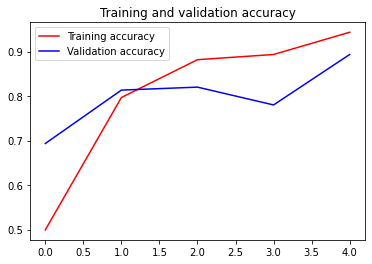

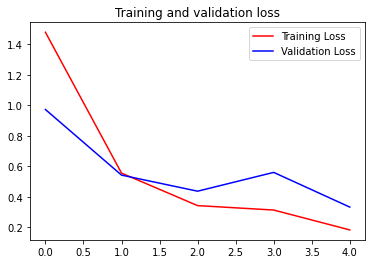

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Guardado del modelo y pesos

In [33]:
model.save_weights(weights_path+'final_weights.h5')
model.save(weights_path+'model.h5')

## Carga de pesos 

In [34]:
model.load_weights(weights_path+'final_weights.h5')

In [26]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f'Test loss: {test_loss}, Test acc: {test_acc}')

Test loss: 0.2463160753250122, Test acc: 0.9200000166893005
